In [51]:
%load_ext autoreload
%autoreload 2

In [52]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import matplotlib.pyplot as plt
import random
import glob

from einops import rearrange, repeat

In [53]:
from dataset import *

SEED = 8
DATASET_SIZE = 40000

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

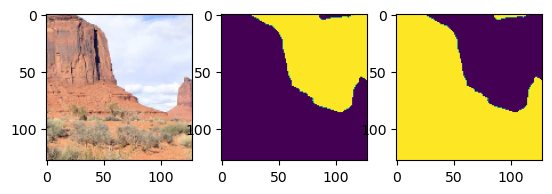

In [54]:
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(256),
    v2.RandomCrop(size=(128, 128))
    ])

input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')
val_images = glob.glob('data/validation/GT_IMAGES/*.jpg')

train_dataset = CorrectionImageDataset(input_images, train=False, transform=transform)
validation_dataset = CorrectionImageDataset('data/validation/GT_IMAGES', train=False, transform=transform)

# test set must be done with the same data 
im, mask = train_dataset[0]

fig, axs = plt.subplots(1,3)
axs[0].imshow(im.permute((1,2,0)))
axs[1].imshow(mask) # Unknown region to generate
axs[2].imshow(~mask) # Known region

In [55]:
len(train_dataset)

3535

In [56]:
len(validation_dataset)

25

# Training the model

In [67]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=2
RESIZE_SIZE = 64
IM_SIZE=64


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    #v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [68]:
train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
val_dataset = CorrectionImageDataset(val_images, train=False, transform=transform)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")

dataloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=6, 
                        persistent_workers=True,
                        pin_memory=True)
valdataloader = DataLoader(val_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           persistent_workers=True,
                           num_workers=6,
                           pin_memory=True)

train(dataloader, valdataloader, device=device, T=250, img_size=IM_SIZE, channels=64, batch_size=BATCH_SIZE)

Model will run on cuda


03:35:48 - INFO: Starting epoch 1:
 94%|██████████████████████████████████████████████████████████    | 1656/1768 [1:30:20<06:10,  3.31s/it, MSE=0.000209]

In [52]:
(~m.unsqueeze(1)).shape

torch.Size([2, 1, 64, 64])

In [78]:
x_known = x * ~m.unsqueeze(1)
x_unknown = x * m.unsqueeze(1)

In [54]:
img_known = np.einsum('xabc->bca', x_known)

In [55]:
x.shape

torch.Size([2, 3, 64, 64])

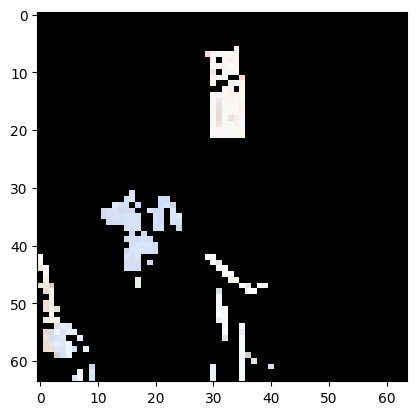

In [80]:
plt.imshow(np.einsum('abc->bca', x_unknown[1]))

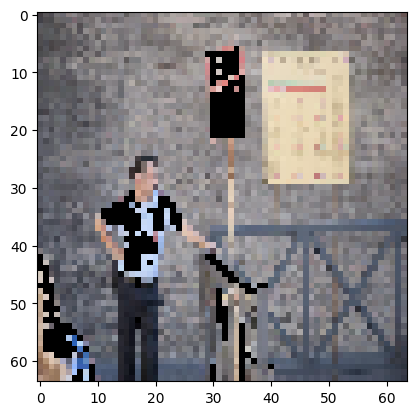

In [81]:
plt.imshow( np.einsum('abc->bca', x_known[1]))

# algo: 
## q-sample
* we do it normally, for full image
* after everything we apply masks to each of the noised image

## p sample 
* we take noised image and denoise it
* we apply masks and get values only for the maksed regions
* we then add corresponding noised image from the q sample with masks 

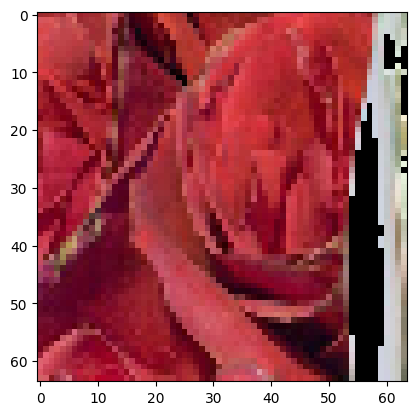

In [38]:
plt.imshow(img_known)

In [ ]:
torch. x_known

In [ ]:
torch.

tensor(0.)


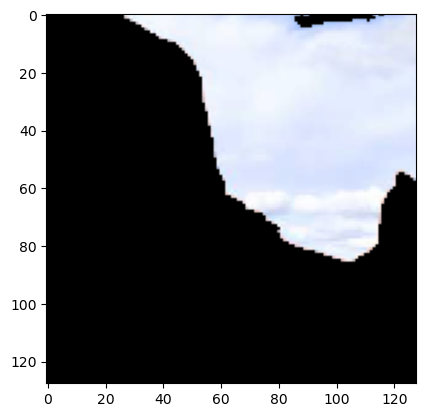

In [50]:
set_seed(SEED)
im, mask = train_dataset[0]


# Apply the mask to all three channels of the image
result = im * mask.unsqueeze(0)
print(result[0,0,0])
plt.imshow(result.permute(1,2,0))
plt.show()